In [31]:
#The data is preprocessed as part of EDA

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score


# Load dataset
df = pd.read_csv("/content/sample_data/Aseries_allcap_drv_logpage_Dec'24_superset 1.csv")

#Based on the data, selecting the most relevant features:

selected_features = [
    'power_on_hours',
    'available_spares_percentage',
    'dvc_glist_ct',
    'average_erase_block_count',
    'max_erase_block_count',
    'host_write_block_count',
    'total_nand_write_block_count',
    'number_of_disks',  # Numeric
]

# Check for missing values
print(df[selected_features].head)
print(df[selected_features].isnull().sum())

# Simple strategy: fill numeric NaNs with median, categorical with mode
for col in selected_features:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

#Encode Categorical Variables
#categorical = ['dvc_disk_type', 'dvc_model']
#df_encoded = pd.get_dummies(df[selected_features], columns=categorical)

df_encoded = df[selected_features]

# Feature Engineering (Optional but Useful)
#df_encoded['write_amplification'] = df['total_nand_write_block_count'] / (df['host_write_block_count'] + 1e-6)
#df_encoded['age_days'] = df['power_on_hours'] / 24

# Build a Predictive Model
X = df_encoded
y = df['rated_life_used']

# Split Data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bin the target variable into 5 categories
y_binned = np.floor(pd.qcut(y, q=5, labels=False, duplicates='drop'))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y_binned
)



<bound method NDFrame.head of        power_on_hours  available_spares_percentage  dvc_glist_ct  \
0                9693                          100             0   
1               20129                          100             0   
2               23225                          100             0   
3               38806                          100             0   
4                9705                          100             0   
...               ...                          ...           ...   
49419            9705                          100             0   
49420           20185                          100             0   
49421            9705                          100             0   
49422            9705                          100             0   
49423            9705                          100             0   

       average_erase_block_count  max_erase_block_count  \
0                             34                    106   
1                            107   

In [32]:
#Linear Regression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

#Evaluate the model
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lin))
linear_mse = mean_squared_error(y_test, y_pred_lin)
print("RMSE:", np.sqrt(linear_mse))
print("Linear Regression R2:", r2_score(y_test, y_pred_lin))
#print("Linear Regression Coefficients:", linreg.coef_)
#print("Linear Regression Intercept:", linreg.intercept_)
print()

#Feature Importance
feature_importance = pd.Series(linreg.coef_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)



Linear Regression MAE: 0.136783030785233
RMSE: 0.30479937119344036
Linear Regression R2: 0.9623015922914437

average_erase_block_count       1.072921e-02
available_spares_percentage     1.075417e-05
total_nand_write_block_count    1.638288e-13
host_write_block_count         -9.183402e-14
power_on_hours                 -1.475346e-05
dvc_glist_ct                   -6.257943e-04
number_of_disks                -1.389592e-03
max_erase_block_count          -2.585937e-03
dtype: float64


In [33]:

# Polynomial Regression (with Linear Regression)
poly_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('linreg', LinearRegression())
])

param_grid_poly = {
    'poly__degree': [1, 2, 3],  # Try linear, quadratic, cubic
    'poly__include_bias': [False]
}

grid_poly = GridSearchCV(poly_pipeline, param_grid_poly, cv=5, scoring='neg_mean_absolute_error')
grid_poly.fit(X_train, y_train)

y_pred_poly = grid_poly.predict(X_test)
print("Polynomial Regression Best Params:", grid_poly.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_poly))
poly_mse = mean_squared_error(y_test, y_pred_poly)
print("RMSE:", np.sqrt(poly_mse))
print("R^2:", r2_score(y_test, y_pred_poly))

#Feature Importance
# Get the PolynomialFeatures transformer from the best estimator
poly_transformer = grid_poly.best_estimator_.named_steps['poly']

# Get the names of the expanded polynomial features
polynomial_feature_names = poly_transformer.get_feature_names_out(X_train.columns)

# Get the coefficients from the linear regression step
coefficients = grid_poly.best_estimator_.named_steps['linreg'].coef_

# Create the Series using the polynomial feature names
feature_importance = pd.Series(coefficients, index=polynomial_feature_names)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)



Polynomial Regression Best Params: {'poly__degree': 3, 'poly__include_bias': False}
MAE: 0.03645986267452077
RMSE: 0.08292840206131448
R^2: 0.9972093750821959
power_on_hours dvc_glist_ct                                              2721.632276
power_on_hours average_erase_block_count total_nand_write_block_count    1717.638039
dvc_glist_ct total_nand_write_block_count                                1463.940885
max_erase_block_count total_nand_write_block_count                       1387.557969
power_on_hours dvc_glist_ct number_of_disks                              1032.306671
                                                                            ...     
dvc_glist_ct average_erase_block_count                                   -936.541902
average_erase_block_count total_nand_write_block_count                   -985.883176
power_on_hours max_erase_block_count total_nand_write_block_count       -1735.076827
dvc_glist_ct number_of_disks                                            -259

In [34]:
# Ridge Regression (with Polynomial Features)
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),  # Removed fixed degree=2 to allow gridsearch to control it
    ('ridge', Ridge())
])

param_grid_ridge = {
    'poly__degree': [1, 2, 3],
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5, scoring='neg_mean_absolute_error')
grid_ridge.fit(X_train, y_train)

y_pred_ridge = grid_ridge.predict(X_test)
print("Ridge Regression Best Params:", grid_ridge.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print("RMSE:", np.sqrt(ridge_mse))
print("R^2:", r2_score(y_test, y_pred_ridge))

# Feature Importance
# Get the PolynomialFeatures transformer from the best estimator
poly_transformer_ridge = grid_ridge.best_estimator_.named_steps['poly']

# Get the names of the expanded polynomial features
polynomial_feature_names_ridge = poly_transformer_ridge.get_feature_names_out(X_train.columns)

# Get the coefficients from the ridge step
coefficients_ridge = grid_ridge.best_estimator_.named_steps['ridge'].coef_

# Create the Series using the polynomial feature names
feature_importance = pd.Series(coefficients_ridge, index=polynomial_feature_names_ridge)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)



Ridge Regression Best Params: {'poly__degree': 3, 'ridge__alpha': 0.01}
MAE: 0.05112534105507957
RMSE: 0.11627356463313693
R^2: 0.9945139868088992
host_write_block_count                                                           32.793939
power_on_hours host_write_block_count number_of_disks                            15.704680
average_erase_block_count host_write_block_count total_nand_write_block_count    14.700615
max_erase_block_count total_nand_write_block_count                               10.859461
max_erase_block_count^2 host_write_block_count                                    9.570681
                                                                                   ...    
host_write_block_count total_nand_write_block_count                              -9.074517
total_nand_write_block_count^2                                                   -9.759219
average_erase_block_count^2 host_write_block_count                              -13.794671
power_on_hours^2 host_write_block_

In [35]:
# Lasso Regression (with Polynomial Features)
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()), # Removed degree=2, include_bias=False to allow GridSearchCV to control it
    ('lasso', Lasso())
])

param_grid_lasso = {
    'poly__degree': [1, 2, 3],
    'lasso__alpha': [0.01, 0.1, 1, 10, 100]
}

grid_lasso = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=5, scoring='neg_mean_absolute_error')
grid_lasso.fit(X_train, y_train)

y_pred_lasso = grid_lasso.predict(X_test)
print("Lasso Regression Best Params:", grid_lasso.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
print("RMSE:", np.sqrt(lasso_mse))
print("R^2:", r2_score(y_test, y_pred_lasso))

#Feature Importance
# Get the PolynomialFeatures transformer from the best estimator
poly_transformer_lasso = grid_lasso.best_estimator_.named_steps['poly']

# Get the names of the expanded polynomial features
polynomial_feature_names_lasso = poly_transformer_lasso.get_feature_names_out(X_train.columns)

# Get the coefficients from the lasso step
coefficients_lasso = grid_lasso.best_estimator_.named_steps['lasso'].coef_

# Create the Series using the polynomial feature names
feature_importance = pd.Series(coefficients_lasso, index=polynomial_feature_names_lasso)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)



Lasso Regression Best Params: {'lasso__alpha': 0.01, 'poly__degree': 3}
MAE: 0.06322290143251096
RMSE: 0.172291392429885
R^2: 0.9879545775639632
average_erase_block_count^2                                 0.748279
average_erase_block_count                                   0.679044
power_on_hours average_erase_block_count number_of_disks    0.094176
power_on_hours number_of_disks                              0.043504
total_nand_write_block_count number_of_disks^2              0.035185
                                                              ...   
host_write_block_count^2                                   -0.013746
number_of_disks                                            -0.021118
average_erase_block_count^3                                -0.039466
average_erase_block_count number_of_disks                  -0.121642
power_on_hours average_erase_block_count^2                 -0.156387
Length: 165, dtype: float64


In [36]:
# Random Forest Regressor
#rf = RandomForestRegressor(n_estimators=100, random_state=42)
#rf.fit(X_train, y_train)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],         # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],         # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]           # Minimum samples required at each leaf node
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # You can also use 'r2', 'neg_mean_squared_error', etc.
    n_jobs=-1,  # Use all available cores
    verbose=2   # Print progress
)

# Fit to the data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated MAE:", -grid_search.best_score_)

# Use the best estimator for predictions
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

#Evaluate the Model
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
rf_mse = mean_squared_error(y_test, y_pred_lasso)
print("RMSE:", np.sqrt(rf_mse))
print("R^2:", r2_score(y_test, y_pred_rf))

#Feature Importance
feature_importance = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)

#Feature Importance
#importances = rf.feature_importances_
#indices = importances.argsort()[::-1]
#feature_names = X_train.columns



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated MAE: 0.00012329947296400054
MAE: 1.6691957511380995e-05
RMSE: 0.172291392429885
R^2: 0.9999996890426425
average_erase_block_count       0.937794
power_on_hours                  0.020627
host_write_block_count          0.019539
total_nand_write_block_count    0.015215
max_erase_block_count           0.003520
number_of_disks                 0.003299
dvc_glist_ct                    0.000006
available_spares_percentage     0.000000
dtype: float64


In [37]:
#Decision Tree Regressor

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20]
}

# Initialize the model
dt = DecisionTreeRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # or 'r2', 'neg_mean_squared_error', etc.
    n_jobs=-1
)

# Fit to the data
grid_search.fit(X_train, y_train)
y_pred_dt = grid_search.best_estimator_.predict(X_test)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated MAE:", -grid_search.best_score_)

print("Decision Tree MAE:", mean_absolute_error(y_test, y_pred_dt))
dt_mse = mean_squared_error(y_test, y_pred_lasso)
print("RMSE:", np.sqrt(dt_mse))
print("Decision Tree R2:", r2_score(y_test, y_pred_dt))


# Cross-validation for MAE (neg_mean_absolute_error)
mae_scores = cross_val_score(dt, X, y, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -mae_scores  # Convert to positive MAE

# Cross-validation for RMSE (neg_root_mean_squared_error, available in sklearn >= 0.22)
rmse_scores = cross_val_score(dt, X, y, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -rmse_scores  # Convert to positive RMSE

# Cross-validation for R2
r2_scores = cross_val_score(dt, X, y, cv=5, scoring='r2')

print(f"Decision Tree Cross-Validated MAE: {mae_scores.mean():.6f} \u00b1 {mae_scores.std():.6f}")
print(f"Decision Tree Cross-Validated RMSE: {rmse_scores.mean():.6f} \u00b1 {rmse_scores.std():.6f}")
print(f"Decision Tree Cross-Validated R2: {r2_scores.mean():.6f} \u00b1 {r2_scores.std():.6f}")

#Feature Importance
# Access feature importances from the best fitted estimator
feature_importance = pd.Series(grid_search.best_estimator_.feature_importances_, index=X_train.columns)
feature_importance
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)




Best parameters: {'max_depth': 7, 'min_samples_split': 2}
Best cross-validated MAE: -0.0
Decision Tree MAE: 0.0
RMSE: 0.172291392429885
Decision Tree R2: 1.0
Decision Tree Cross-Validated MAE: 0.000000 ± 0.000000
Decision Tree Cross-Validated RMSE: 0.000000 ± 0.000000
Decision Tree Cross-Validated R2: 1.000000 ± 0.000000
average_erase_block_count       0.937010
total_nand_write_block_count    0.025902
power_on_hours                  0.020145
host_write_block_count          0.009362
max_erase_block_count           0.004240
number_of_disks                 0.003295
dvc_glist_ct                    0.000046
available_spares_percentage     0.000000
dtype: float64


In [38]:
#Support Vector Regressor
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

print("SVR MAE:", mean_absolute_error(y_test, y_pred_svr))
print("SVR RMSE:", np.sqrt(mean_absolute_error(y_test, y_pred_svr)))
print("SVR R2:", r2_score(y_test, y_pred_svr))


#Permutation Importance
result = permutation_importance(svr, X_test, y_test, n_repeats=10, random_state=42)
perm_fi = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)
print("SVR Permutation Importances:")
print(perm_fi.head(10))
#perm_fi.head(20).plot(kind='bar', figsize=(12,4), title="SVR Permutation Importances")
#plt.tight_layout()
#plt.show()

#Prediction for New Data
#To predict for a new SSD row, use:

# new_data should be a DataFrame with the same columns as X_train
#y_new_pred = svr.predict(new_data)  # Example with Random Forest


SVR MAE: 0.07828760122646099
SVR RMSE: 0.2797992159146644
SVR R2: 0.9941531689171642
SVR Permutation Importances:
average_erase_block_count       1.516685
power_on_hours                  0.265587
total_nand_write_block_count    0.244839
max_erase_block_count           0.224673
host_write_block_count          0.128981
number_of_disks                 0.032770
dvc_glist_ct                    0.026055
available_spares_percentage     0.023929
dtype: float64


In [39]:
results = pd.DataFrame({
    'Model': ['Linear', 'Polynomial', 'Ridge', 'Lasso', 'Random Forest', 'Decision Tree', 'Support Vector'],
    #'Best Params': [{}, grid_poly.best_params_, grid_ridge.best_params_, grid_lasso.best_params_, {}, {}, {}],
    'MAE': [
        mean_absolute_error(y_test, y_pred_lin),
        mean_absolute_error(y_test, y_pred_poly),
        mean_absolute_error(y_test, y_pred_ridge),
        mean_absolute_error(y_test, y_pred_lasso),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_dt),
        mean_absolute_error(y_test, y_pred_svr)
    ],
    'RMSE': [
        np.sqrt(mean_absolute_error(y_test, y_pred_lin)),
        np.sqrt(mean_absolute_error(y_test, y_pred_poly)),
        np.sqrt(mean_absolute_error(y_test, y_pred_ridge)),
        np.sqrt(mean_absolute_error(y_test, y_pred_lasso)),
        np.sqrt(mean_absolute_error(y_test, y_pred_rf)),
        np.sqrt(mean_absolute_error(y_test, y_pred_dt)),
        np.sqrt(mean_absolute_error(y_test, y_pred_svr))
    ],
    'R2': [
        r2_score(y_test, y_pred_lin),
        r2_score(y_test, y_pred_poly),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_lasso),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_dt),
        r2_score(y_test, y_pred_svr)
    ]
})
#print(results)
display(results.style.background_gradient(cmap='Blues'))


,Model,MAE,RMSE,R2
0,Linear,0.136783,0.369842,0.962302
1,Polynomial,0.036460,0.190945,0.997209
2,Ridge,0.051125,0.226109,0.994514
3,Lasso,0.063223,0.251442,0.987955
4,Random Forest,0.000017,0.004086,1.000000
5,Decision Tree,0.000000,0.000000,1.000000
6,Support Vector,0.078288,0.279799,0.994153


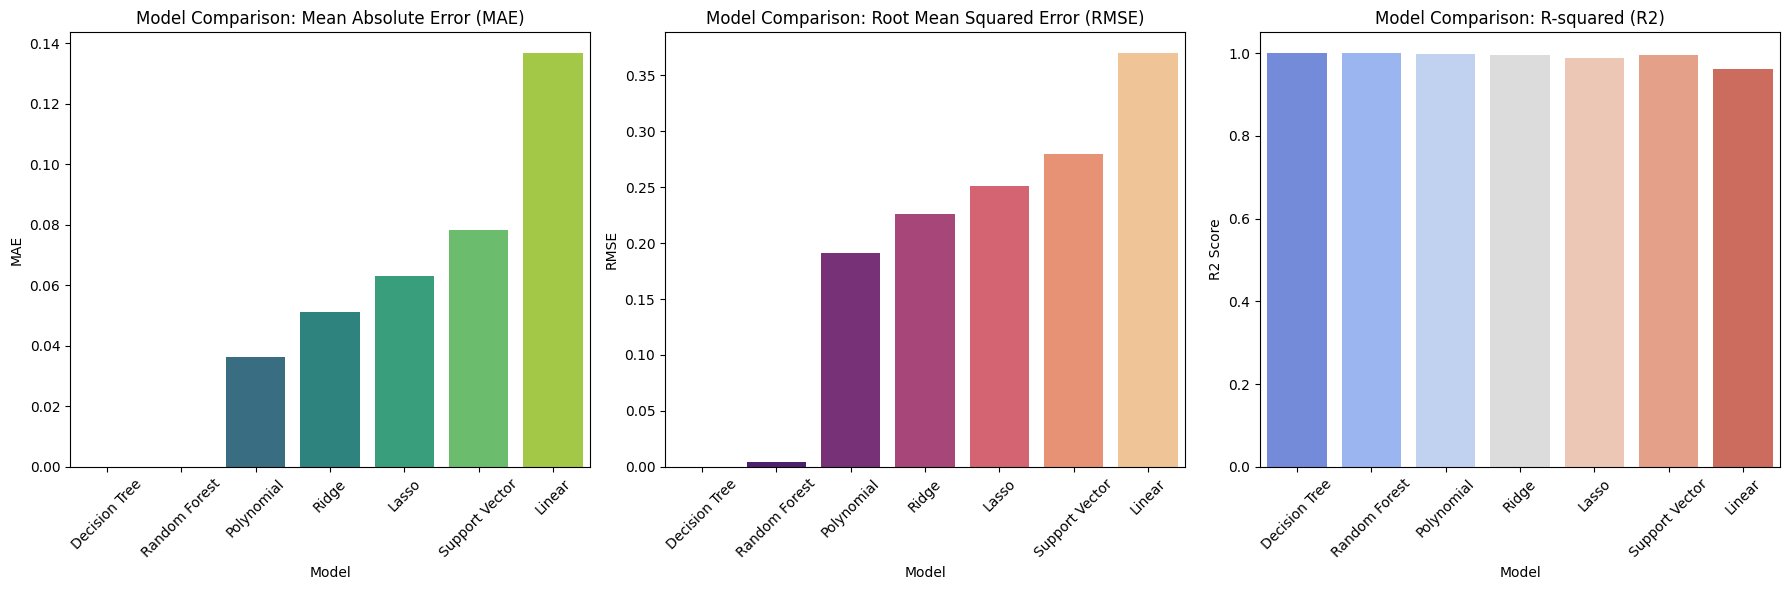

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort results by MAE for consistent plotting order
results_sorted = results.sort_values(by='MAE', ascending=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Plot MAE
sns.barplot(ax=axes[0], x='Model', y='MAE', data=results_sorted, palette='viridis')
axes[0].set_title('Model Comparison: Mean Absolute Error (MAE)')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)

# Plot RMSE
sns.barplot(ax=axes[1], x='Model', y='RMSE', data=results_sorted, palette='magma')
axes[1].set_title('Model Comparison: Root Mean Squared Error (RMSE)')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=45)

# Plot R2
sns.barplot(ax=axes[2], x='Model', y='R2', data=results_sorted, palette='coolwarm')
axes[2].set_title('Model Comparison: R-squared (R2)')
axes[2].set_ylabel('R2 Score')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Modify Random Forest Hyperparameters

### Subtask:
Adjust the `param_grid` for the `RandomForestRegressor` in cell `fUb3U86Te2mU` to include values that help prevent overfitting, such as more restrictive `max_depth` and higher `min_samples_split`/`min_samples_leaf`.


**Reasoning**:
The subtask requires modifying the `param_grid` for the `RandomForestRegressor` in cell `fUb3U86Te2mU` to include values that help prevent overfitting. I will update the specified hyperparameters within the `param_grid` to more restrictive values as instructed.



In [41]:
# Random Forest Regressor
#rf = RandomForestRegressor(n_estimators=100, random_state=42)
#rf.fit(X_train, y_train)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],         # Number of trees in the forest
    'max_depth': [5, 10, 15],         # Maximum depth of each tree
    'min_samples_split': [5, 10, 20],        # Minimum samples required to split a node
    'min_samples_leaf': [2, 4, 8]           # Minimum samples required at each leaf node
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # You can also use 'r2', 'neg_mean_squared_error', etc.
    n_jobs=-1,  # Use all available cores
    verbose=2   # Print progress
)

# Fit to the data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated MAE:", -grid_search.best_score_)

# Use the best estimator for predictions
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

#Evaluate the Model
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_absolute_error(y_test, y_pred_rf)))
print("R^2:", r2_score(y_test, y_pred_rf))

#Feature Importance
feature_importance = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)

#Feature Importance
#importances = rf.feature_importances_
#indices = importances.argsort()[::-1]
#feature_names = X_train.columns

#plt.figure(figsize=(10,8))
#plt.title("Feature Importances")
#plt.bar(range(len(importances)), importances[indices])
#plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
#plt.tight_layout()
#plt.show()

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validated MAE: 0.0002584898645014265
MAE: 4.966479594704223e-05
RMSE: 0.007047325446369156
R^2: 0.9999990453485863
average_erase_block_count       0.938005
power_on_hours                  0.020453
host_write_block_count          0.018945
total_nand_write_block_count    0.015844
max_erase_block_count           0.003539
number_of_disks                 0.003211
dvc_glist_ct                    0.000004
available_spares_percentage     0.000000
dtype: float64
